In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/data_wage.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/sample_data/data')

In [2]:
!pip install openfoamparser_mai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for openfoamparser_mai: filename=openfoamparser_mai-0.14-py3-none-any.whl size=10070 sha256=6746bba0ea580ef76eb2b407a25b404846705023b2a849a7a0df814ec54d6924
  Stored in directory: /root/.cache/pip/wheels/e7/87/ab/152f3f7312bc7b75994a0fc94d58a1d0c45a4084fbf1947bee
Successfully built openfoamparser_mai


In [3]:
import openfoamparser_mai as Ofpp

In [ ]:
V = Ofpp.parse_internal_field('/content/drive/MyDrive/sample_data/data/data_wage/low_dim/vel3.0/0.2/U')

In [ ]:
vx, vy = V[:,0], V[:,1]

In [4]:
!pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 13.1 MB/s eta 0:00:00


Compiling model...
Building feed-forward neural network...
'build' took 0.098955 s



/usr/local/lib/python3.9/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 4.785832 s

Initializing variables...
Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [3.51e-02, 4.74e-02, 2.99e-01, 8.34e+00, 6.96e-02]    [3.51e-02, 4.74e-02, 2.99e-01, 8.34e+00, 6.96e-02]    []  
1000      [1.86e-03, 4.43e-04, 9.29e-04, 2.59e-02, 5.96e-02]    [1.86e-03, 4.43e-04, 9.29e-04, 2.59e-02, 5.96e-02]    []  
2000      [1.05e-03, 6.54e-04, 6.74e-04, 1.87e-02, 3.85e-02]    [1.05e-03, 6.54e-04, 6.74e-04, 1.87e-02, 3.85e-02]    []  
3000      [4.21e-04, 3.48e-04, 4.13e-04, 1.35e-02, 3.89e-02]    [4.21e-04, 3.48e-04, 4.13e-04, 1.35e-02, 3.89e-02]    []  
4000      [2.83e-04, 2.36e-04, 1.78e-04, 1.26e-02, 3.92e-02]    [2.83e-04, 2.36e-04, 1.78e-04, 1.26e-02, 3.92e-02]    []  
5000      [1.67e-04, 4.34e-04, 9.64e-05, 1.23e-02, 3.92e-02]    [1.67e-04, 4.34e-04, 9.64e-05, 1.23e-02, 3.92e-02]    []  
6000      [9.67e-05, 1.99e-04, 3.06e-05, 1.21e-02, 3.91e-02]

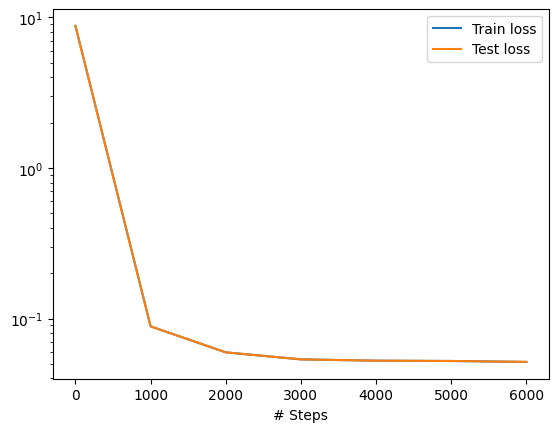

Mean residual: 0.007447958


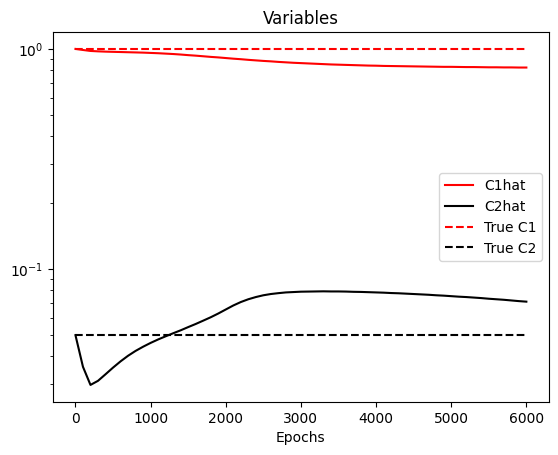

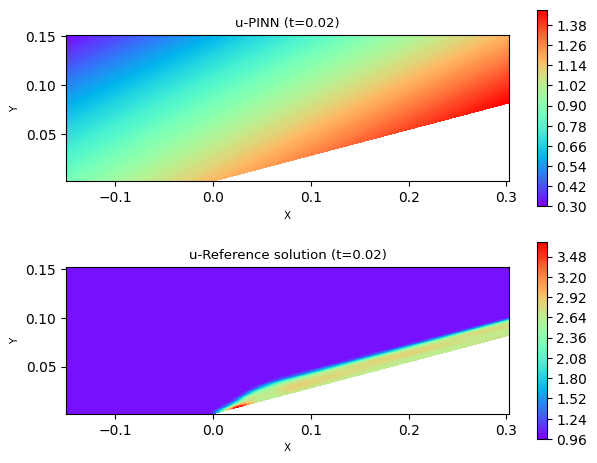

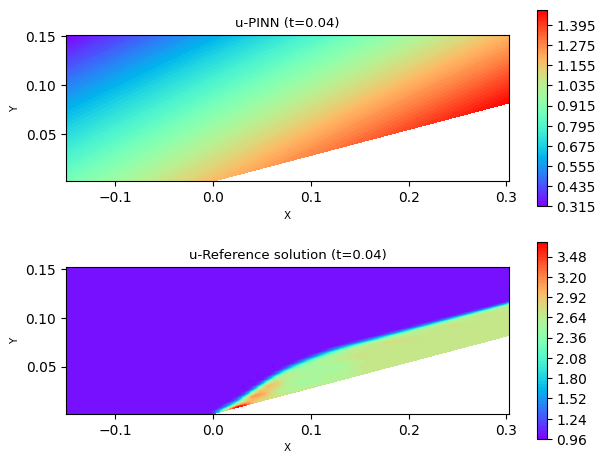

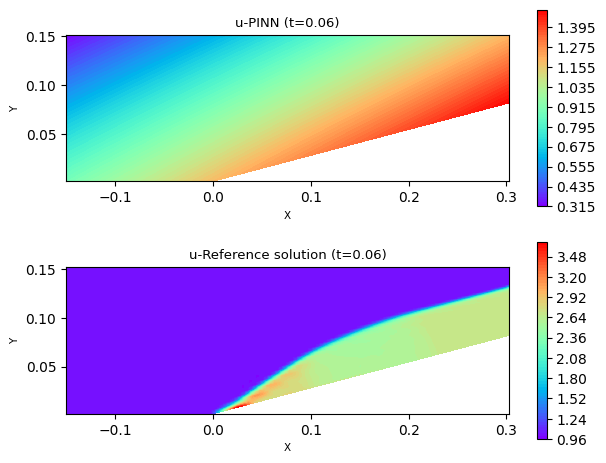

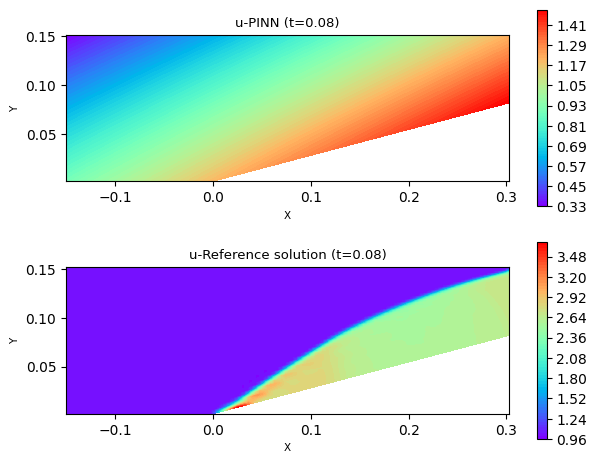

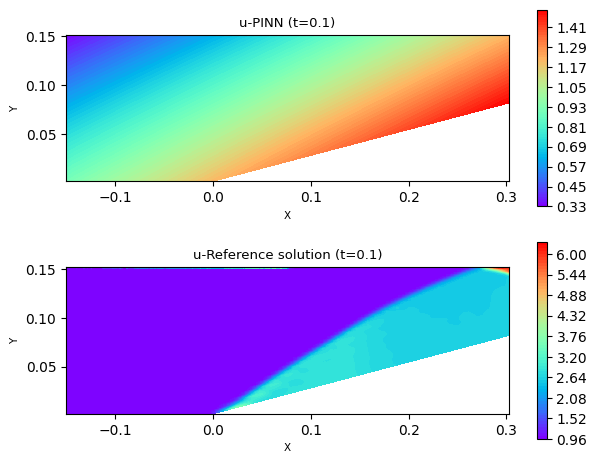

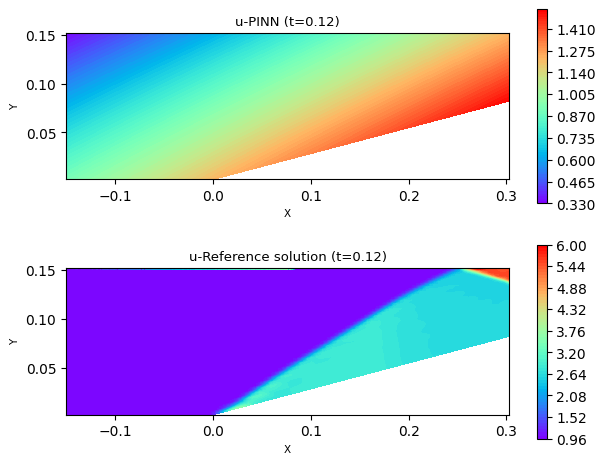

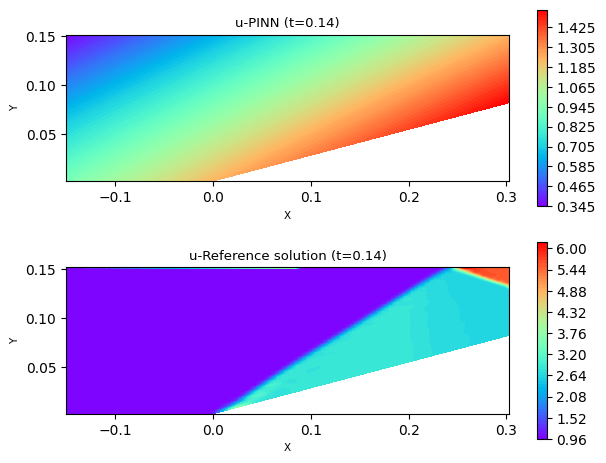

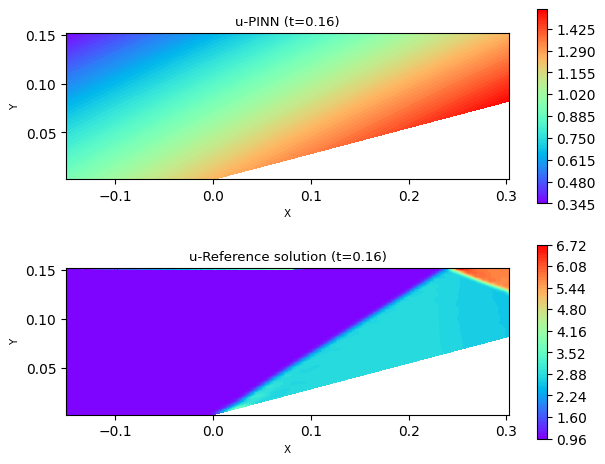

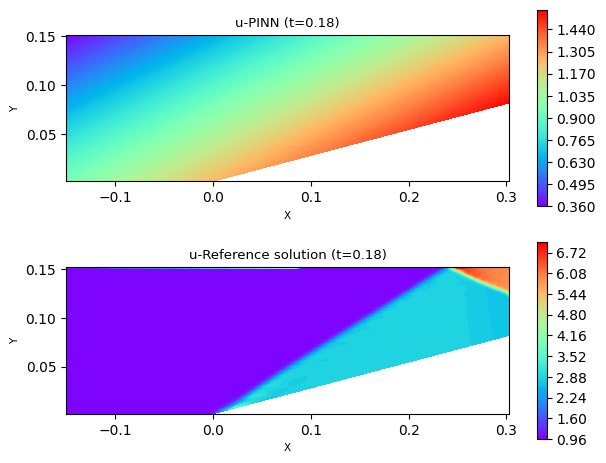

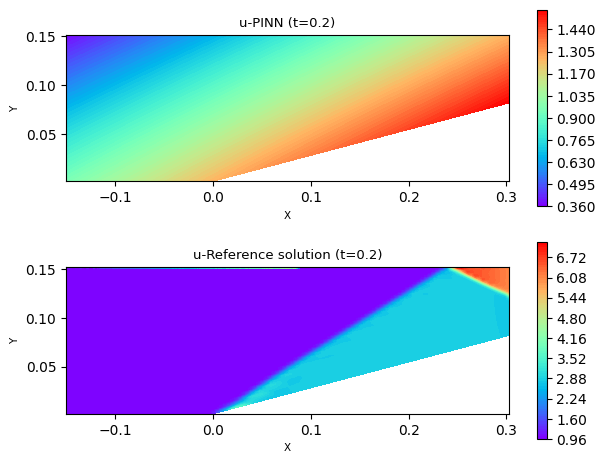

In [18]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle
An inverse problem of the Navier-Stokes equation of incompressible flow around cylinder with Re=100
References: https://doi.org/10.1016/j.jcp.2018.10.045 Section 4.1.1
"""

import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import re

# true values
C1true = 1.0
C2true = 0.05

# Load training data
def load_training_data(num, res):
    # Заставил считывать наши данные аналогично .mat файлу
    t_star = np.array([0.02*(i+1) for i in range(10)]).reshape((10,1))  # T x 1
    U_star = np.array([Ofpp.parse_internal_field('/content/drive/MyDrive/sample_data/data/data_wage/'+res+'_dim/vel3.0/'+str(t)+'/U') for t in t_star[:,0]]) # N x 2 x T
    U_star = np.transpose(U_star, (1, 2, 0))
    P_star = np.array([Ofpp.parse_internal_field('/content/drive/MyDrive/sample_data/data/data_wage/'+res+'_dim/vel3.0/'+str(t)+'/p') for t in t_star[:,0]])  # N x T
    P_star = np.transpose(P_star, (1, 0))
    X_star = Ofpp.parse_internal_field('/content/drive/MyDrive/C_wage_'+res)  # N x 2
    N = X_star.shape[0]
    T = t_star.shape[0]
    # Rearrange Data
    XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
    YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
    TT = np.tile(t_star, (1, N)).T  # N x T
    UU = U_star[:, 0, :]  # N x T
    VV = U_star[:, 1, :]  # N x T
    PP = P_star  # N x T
    x = XX.flatten()[:, None]  # NT x 1
    y = YY.flatten()[:, None]  # NT x 1
    t = TT.flatten()[:, None]  # NT x 1
    u = UU.flatten()[:, None]  # NT x 1
    v = VV.flatten()[:, None]  # NT x 1
    p = PP.flatten()[:, None]  # NT x 1
    # training domain: X × Y = [1, 8] × [−2, 2] and T = [0, 7]
    data1 = np.concatenate([x, y, t, u, v, p], 1)
    # data2 = data1[:, :][data1[:, 2] <= 7]
    # data3 = data2[:, :][data2[:, 0] >= 1]
    # data4 = data3[:, :][data3[:, 0] <= 8]
    # data5 = data4[:, :][data4[:, 1] >= -2]
    # data_domain = data5[:, :][data5[:, 1] <= 2]
    data_domain = data1
    # choose number of training points: num =7000
    idx = np.random.choice(data_domain.shape[0], num, replace=False)
    x_train = data_domain[idx, 0:1]
    y_train = data_domain[idx, 1:2]
    t_train = data_domain[idx, 2:3]
    u_train = data_domain[idx, 3:4]
    v_train = data_domain[idx, 4:5]
    p_train = data_domain[idx, 5:6]
    return [x_train, y_train, t_train, u_train, v_train, p_train]

# Parameters to be identified
C1 = dde.Variable(1.0)
C2 = dde.Variable(0.05)

# Define Navier Stokes Equations (Time-dependent PDEs)
def Navier_Stokes_Equation(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]
    p = y[:, 2:3]
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    du_t = dde.grad.jacobian(y, x, i=0, j=2)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dv_t = dde.grad.jacobian(y, x, i=1, j=2)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    continuity = du_x + dv_y
    x_momentum = du_t + C1 * (u * du_x + v * du_y) + dp_x - C2 * (du_xx + du_yy)
    y_momentum = dv_t + C1 * (u * dv_x + v * dv_y) + dp_y - C2 * (dv_xx + dv_yy)
    return [continuity, x_momentum, y_momentum]

# Define Spatio-temporal domain
# Rectangular
Lx_min, Lx_max = -0.16, 0.31
Ly_min, Ly_max = -0.1, 0.15
# Spatial domain: X × Y = [1, 8] × [−2, 2]
space_domain = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])
# Time domain: T = [0, 7]
time_domain = dde.geometry.TimeDomain(0, 0.2)
# Spatio-temporal domain
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

# Get the training data: num = N*T
[ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=75*10, res='low') # новый размер выборки!!!
ob_xyt = np.hstack((ob_x, ob_y, ob_t))
observe_u = dde.icbc.PointSetBC(ob_xyt, ob_u, component=0)
observe_v = dde.icbc.PointSetBC(ob_xyt, ob_v, component=1)

# Training datasets and Loss
data = dde.data.TimePDE(
    geomtime,
    Navier_Stokes_Equation,
    [observe_u, observe_v],
    num_domain=700,
    num_boundary=200,
    num_initial=100,
    anchors=ob_xyt,
)

# Neural Network setup
layer_size = [3] + [50] * 6 + [3]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)

# callbacks for storing results
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue([C1, C2], period=100, filename=fnamevar)

# Compile, train and save model
# model.compile("adam", lr=1e-3, external_trainable_variables=[C1, C2])
# loss_history, train_state = model.train(
#     iterations=10000, callbacks=[variable], display_every=1000, disregard_previous_best=True
# )
#dde.saveplot(loss_history, train_state, issave=True, isplot=True)
model.compile("adam", lr=1e-4, external_trainable_variables=[C1, C2])
loss_history, train_state = model.train(
    epochs=6000, callbacks=[variable], display_every=1000, disregard_previous_best=True
)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)
# model.save(save_path = "./NS_inverse_model/model")
f = model.predict(ob_xyt, operator=Navier_Stokes_Equation)
print("Mean residual:", np.mean(np.absolute(f)))

# Plot Variables:
# reopen saved data using callbacks in fnamevar
lines = open(fnamevar, "r").readlines()
# read output data in fnamevar
Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
l, c = Chat.shape
plt.semilogy(range(0, l * 100, 100), Chat[:, 0], "r-")
plt.semilogy(range(0, l * 100, 100), Chat[:, 1], "k-")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 0].shape) * C1true, "r--")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 1].shape) * C2true, "k--")
plt.legend(["C1hat", "C2hat", "True C1", "True C2"], loc="right")
plt.xlabel("Epochs")
plt.title("Variables")
plt.show()

# Plot the velocity distribution of the flow field:
for t in [0.02*(i+1) for i in range(10)]: #Изменил t
    [ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=4800*10, res='high') # новый размер выборки!!!
    xyt_pred = np.hstack((ob_x, ob_y, t * np.ones((len(ob_x), 1))))
    uvp_pred = model.predict(xyt_pred)
    x_pred, y_pred, t_pred = xyt_pred[:, 0], xyt_pred[:, 1], xyt_pred[:, 2]
    u_pred, v_pred, p_pred = uvp_pred[:, 0], uvp_pred[:, 1], uvp_pred[:, 2]
    x_true = ob_x[ob_t == t]
    y_true = ob_y[ob_t == t]
    p_true = ob_p[ob_t == t]
    fig, ax = plt.subplots(2, 1)
    cntr0 = ax[0].tricontourf(x_pred, y_pred, p_pred, levels=80, cmap="rainbow")
    cb0 = plt.colorbar(cntr0, ax=ax[0])
    cntr1 = ax[1].tricontourf(x_true, y_true, p_true, levels=80, cmap="rainbow")
    cb1 = plt.colorbar(cntr1, ax=ax[1])
    ax[0].set_title("u-PINN " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[0].axis("scaled")
    ax[0].set_xlabel("X", fontsize=7.5, family="Arial")
    ax[0].set_ylabel("Y", fontsize=7.5, family="Arial")
    ax[1].set_title("u-Reference solution " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[1].axis("scaled")
    ax[1].set_xlabel("X", fontsize=7.5, family="Arial")
    ax[1].set_ylabel("Y", fontsize=7.5, family="Arial")
    fig.tight_layout()
    plt.show()

In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle
An inverse problem of the Navier-Stokes equation of incompressible flow around cylinder with Re=100
References: https://doi.org/10.1016/j.jcp.2018.10.045 Section 4.1.1
"""
# исходник с парой принтов для ясности

import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import re

# true values
C1true = 1.0
C2true = 0.01

# Load training data
def load_training_data(num):
    data = loadmat("/content/cylinder_nektar_wake.mat")
    U_star = data["U_star"]  # N x 2 x T
    print(U_star.shape)
    P_star = data["p_star"]  # N x T
    print(P_star.shape)
    t_star = data["t"]  # T x 1
    print(t_star.shape)
    X_star = data["X_star"]  # N x 2
    print(X_star.shape)
    N = X_star.shape[0]
    T = t_star.shape[0]
    # Rearrange Data
    XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
    print(XX.shape)
    YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
    print(YY.shape)
    TT = np.tile(t_star, (1, N)).T  # N x T
    print(TT.shape)
    UU = U_star[:, 0, :]  # N x T
    print(UU.shape)
    VV = U_star[:, 1, :]  # N x T
    print(VV.shape)
    PP = P_star  # N x T
    print(PP.shape)
    x = XX.flatten()[:, None]  # NT x 1
    y = YY.flatten()[:, None]  # NT x 1
    t = TT.flatten()[:, None]  # NT x 1
    u = UU.flatten()[:, None]  # NT x 1
    v = VV.flatten()[:, None]  # NT x 1
    p = PP.flatten()[:, None]  # NT x 1
    # training domain: X × Y = [1, 8] × [−2, 2] and T = [0, 7]
    data1 = np.concatenate([x, y, t, u, v, p], 1)
    data2 = data1[:, :][data1[:, 2] <= 7]
    data3 = data2[:, :][data2[:, 0] >= 1]
    data4 = data3[:, :][data3[:, 0] <= 8]
    data5 = data4[:, :][data4[:, 1] >= -2]
    data_domain = data5[:, :][data5[:, 1] <= 2]
    print(data_domain.shape)
    # choose number of training points: num =7000
    idx = np.random.choice(data_domain.shape[0], num, replace=False)
    x_train = data_domain[idx, 0:1]
    y_train = data_domain[idx, 1:2]
    t_train = data_domain[idx, 2:3]
    u_train = data_domain[idx, 3:4]
    v_train = data_domain[idx, 4:5]
    p_train = data_domain[idx, 5:6]
    return [x_train, y_train, t_train, u_train, v_train, p_train]

# Parameters to be identified
C1 = dde.Variable(0.0)
C2 = dde.Variable(0.0)

# Define Navier Stokes Equations (Time-dependent PDEs)
def Navier_Stokes_Equation(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]
    p = y[:, 2:3]
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    du_t = dde.grad.jacobian(y, x, i=0, j=2)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dv_t = dde.grad.jacobian(y, x, i=1, j=2)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    continuity = du_x + dv_y
    x_momentum = du_t + C1 * (u * du_x + v * du_y) + dp_x - C2 * (du_xx + du_yy)
    y_momentum = dv_t + C1 * (u * dv_x + v * dv_y) + dp_y - C2 * (dv_xx + dv_yy)
    return [continuity, x_momentum, y_momentum]

# Define Spatio-temporal domain
# Rectangular
Lx_min, Lx_max = 1.0, 8.0
Ly_min, Ly_max = -2.0, 2.0
# Spatial domain: X × Y = [1, 8] × [−2, 2]
space_domain = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])
# Time domain: T = [0, 7]
time_domain = dde.geometry.TimeDomain(0, 7)
# Spatio-temporal domain
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

# Get the training data: num = 7000
[ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=7000)
ob_xyt = np.hstack((ob_x, ob_y, ob_t))
observe_u = dde.icbc.PointSetBC(ob_xyt, ob_u, component=0)
observe_v = dde.icbc.PointSetBC(ob_xyt, ob_v, component=1)

# Training datasets and Loss
data = dde.data.TimePDE(
    geomtime,
    Navier_Stokes_Equation,
    [observe_u, observe_v],
    num_domain=700,
    num_boundary=200,
    num_initial=100,
    anchors=ob_xyt,
)

# Neural Network setup
layer_size = [3] + [50] * 6 + [3]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)

# callbacks for storing results
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue([C1, C2], period=100, filename=fnamevar)

# Compile, train and save model
# model.compile("adam", lr=1e-3, external_trainable_variables=[C1, C2])
# loss_history, train_state = model.train(
#     iterations=10000, callbacks=[variable], display_every=1000, disregard_previous_best=True
# )
#dde.saveplot(loss_history, train_state, issave=True, isplot=True)
model.compile("adam", lr=1e-4, external_trainable_variables=[C1, C2])
loss_history, train_state = model.train(
    epochs=10000, callbacks=[variable], display_every=1000, disregard_previous_best=True
)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)
# model.save(save_path = "./NS_inverse_model/model")
f = model.predict(ob_xyt, operator=Navier_Stokes_Equation)
print("Mean residual:", np.mean(np.absolute(f)))

# Plot Variables:
# reopen saved data using callbacks in fnamevar
lines = open(fnamevar, "r").readlines()
# read output data in fnamevar
Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
l, c = Chat.shape
plt.semilogy(range(0, l * 100, 100), Chat[:, 0], "r-")
plt.semilogy(range(0, l * 100, 100), Chat[:, 1], "k-")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 0].shape) * C1true, "r--")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 1].shape) * C2true, "k--")
plt.legend(["C1hat", "C2hat", "True C1", "True C2"], loc="right")
plt.xlabel("Epochs")
plt.title("Variables")
plt.show()

# Plot the velocity distribution of the flow field:
for t in range(0, 8):
    [ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=140000)
    xyt_pred = np.hstack((ob_x, ob_y, t * np.ones((len(ob_x), 1))))
    uvp_pred = model.predict(xyt_pred)
    x_pred, y_pred, t_pred = xyt_pred[:, 0], xyt_pred[:, 1], xyt_pred[:, 2]
    u_pred, v_pred, p_pred = uvp_pred[:, 0], uvp_pred[:, 1], uvp_pred[:, 2]
    x_true = ob_x[ob_t == t]
    y_true = ob_y[ob_t == t]
    u_true = ob_u[ob_t == t]
    fig, ax = plt.subplots(2, 1)
    cntr0 = ax[0].tricontourf(x_pred, y_pred, u_pred, levels=80, cmap="rainbow")
    cb0 = plt.colorbar(cntr0, ax=ax[0])
    cntr1 = ax[1].tricontourf(x_true, y_true, u_true, levels=80, cmap="rainbow")
    cb1 = plt.colorbar(cntr1, ax=ax[1])
    ax[0].set_title("u-PINN " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[0].axis("scaled")
    ax[0].set_xlabel("X", fontsize=7.5, family="Arial")
    ax[0].set_ylabel("Y", fontsize=7.5, family="Arial")
    ax[1].set_title("u-Reference solution " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[1].axis("scaled")
    ax[1].set_xlabel("X", fontsize=7.5, family="Arial")
    ax[1].set_ylabel("Y", fontsize=7.5, family="Arial")
    fig.tight_layout()
    plt.show()

(5000, 2, 200)
(5000, 200)
(200, 1)
(5000, 2)
(5000, 200)
(5000, 200)
(5000, 200)
(5000, 200)
(5000, 200)
(5000, 200)
(355000, 6)
Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.9/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.207581 s

'compile' took 3.339124 s

Initializing variables...
Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [7.37e-03, 3.21e-03, 4.29e-03, 4.31e-01, 7.80e-02]    [7.37e-03, 3.21e-03, 4.29e-03, 4.31e-01, 7.80e-02]    []  


KeyboardInterrupt: ignored